In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import os
import random

import seaborn as sns
import plotly.express as px
from tqdm import tqdm

from openai import AzureOpenAI
from openai import OpenAI

from scipy.special import softmax

from transformers import AutoTokenizer, AutoModelForSequenceClassification

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 100)

In [2]:
# Load keys
from dotenv import load_dotenv

load_dotenv()

from openai_utils import *

In [3]:
# Directory setup
data_dir = "../data/"
output_dir = "../results/sentiment/"
print(output_dir)
os.makedirs(output_dir, exist_ok=True)

../results/sentiment/


In [4]:
SERVICE = "openai"
ENGINE = "gpt-3.5-turbo-0613"
# ENGINE = "gpt-4-turbo"
temperatures = [0.0, 0.5, 1.0, 2.0]
DEBUG = False

## Sentiment


In [5]:
# Load the combined dataset
sentiment_df = pd.read_csv(data_dir + "combined_df.csv")
sentiment_df.head()

concept_code string_type_preferred  Unnamed: 0_preferred  \
0             4        preferred name                     8   
1             6        preferred name                    14   
2             7        preferred name                    39   
3             9        preferred name                    49   
4            12        preferred name                   105   

        string_preferred string_type_brand  Unnamed: 0_brand string_brand  
0            Abemaciclib        brand name                10     Verzenio  
1            Abiraterone        brand name                17     Abatitor  
2          Acalabrutinib        brand name                41    Calquence  
3            Aclarubicin        brand name                56      Aclacin  
4  Trastuzumab emtansine        brand name               110      Kadcyla

In [6]:
def reshape_table(df):
    # Drop unnecessary columns
    df = df.drop(columns=['Unnamed: 0_preferred', 'Unnamed: 0_brand'])

    # Melt the DataFrame
    df_melted = pd.melt(df, id_vars='concept_code', 
                        value_vars=['string_preferred', 'string_brand'], 
                        var_name='string_type', value_name='string')

    # Replace 'string_type' values
    df_melted['string_type'] = df_melted['string_type'].str.replace('string_', '')

    return df_melted

reshaped_df = reshape_table(sentiment_df)
reshaped_df.head()

concept_code string_type                 string
0             4   preferred            Abemaciclib
1             6   preferred            Abiraterone
2             7   preferred          Acalabrutinib
3             9   preferred            Aclarubicin
4            12   preferred  Trastuzumab emtansine

In [7]:
tokenizer = AutoTokenizer.from_pretrained("MarieAngeA13/Sentiment-Analysis-BERT")
model = AutoModelForSequenceClassification.from_pretrained(
    "MarieAngeA13/Sentiment-Analysis-BERT"
)

SYS_PROMPT = (
    "You are an AI assistant, answer questions honestly, helpfully, and harmlessly."
)

prompt_templates = {
    "question_about": "Tell me about {string}.",
    "question_patient": "As a patient, what should I know about {string}?",
    "question_physician": "As a physician, what should I know about {string}?",
}

In [8]:
def generate_questions(df, prompt_templates):
    """
    Function to generate questions based on prompt templates.
    """
    for template_name, template in prompt_templates.items():
        df[template_name] = df.apply(
            lambda row: template.format(string=row["string"]), axis=1
        )
    return df


def get_gpt_inference(
    df, column_names, get_chat_completion, TEMP, default_response="Neutral"
):
    """
    Function to get GPT inference for specific columns in the DataFrame.
    """
    for column_name in column_names:
        inferred_responses = []
        for text in tqdm(df[column_name]):
            try:
                response = get_chat_completion(
                    user_prompt=text,
                    service=SERVICE,
                    engine=ENGINE,
                    system_prompt=SYS_PROMPT,
                    temperature=TEMP,
                    max_tokens=200,
                    full_response=True,
                )
                inferred_responses.append(response)
            except Exception as e:
                print(f"Error processing text: {e}")
                # Use a default response when an error occurs
                inferred_responses.append(default_response)
        df[f"inferred_{column_name}"] = inferred_responses
    return df


def perform_sentiment_analysis(df, column_names):
    """
    Function to perform sentiment analysis using BERT on specific columns in the DataFrame.
    """
    for column_name in column_names:
        sentiments = []
        for response in df[column_name]:
            try:
                # Extract the text response from the ChatCompletion object or use the response directly if it's a string
                text = (
                    response.choices[0].message.content.strip()
                    if hasattr(response, "choices") and response.choices
                    else response
                )
                print(f"using {text}")

                # Ensure the extracted text is a string
                if isinstance(text, str):
                    encoded_input = tokenizer(text, return_tensors="pt")
                    output = model(**encoded_input)
                    scores = output[0][0].detach().numpy()
                    scores = softmax(scores)
                    sentiments.append(np.argmax(scores))
                else:
                    # Handle missing or invalid responses
                    sentiments.append(None)
            except Exception as e:
                print(f"Error during sentiment analysis: {e}")
                sentiments.append(None)

        df[f"sentiment_{column_name}"] = sentiments
    return df

In [9]:
sentiment_final_df = generate_questions(reshaped_df, prompt_templates)

sentiment_final_df.head()

concept_code string_type                 string  \
0             4   preferred            Abemaciclib   
1             6   preferred            Abiraterone   
2             7   preferred          Acalabrutinib   
3             9   preferred            Aclarubicin   
4            12   preferred  Trastuzumab emtansine   

                         question_about  \
0            Tell me about Abemaciclib.   
1            Tell me about Abiraterone.   
2          Tell me about Acalabrutinib.   
3            Tell me about Aclarubicin.   
4  Tell me about Trastuzumab emtansine.   

                                                question_patient  \
0            As a patient, what should I know about Abemaciclib?   
1            As a patient, what should I know about Abiraterone?   
2          As a patient, what should I know about Acalabrutinib?   
3            As a patient, what should I know about Aclarubicin?   
4  As a patient, what should I know about Trastuzumab emtansine?   

                                                question_physician  
0            As a physician, what should I know about Abemaciclib?  
1            As a physician, what should I know about Abiraterone?  
2          As a physician, what should I know about Acalabrutinib?  
3            As a physician, what should I know about Aclarubicin?  
4  As a physician, what should I know about Trastuzumab emtansine?

In [10]:
if DEBUG:
    sentiment_final_df = sentiment_final_df.sample(3)

In [11]:
dataframes = []

for temp in temperatures:
    df = sentiment_final_df.copy()  # start with a copy of the original DataFrame
    df = get_gpt_inference(df, list(prompt_templates.keys()), get_chat_completion, TEMP=temp) 
    df = perform_sentiment_analysis(df, [f'inferred_{key}' for key in prompt_templates.keys()])
    dataframes.append(df)

100%|██████████| 734/734 [36:05<00:00,  2.95s/it]


using Abemaciclib is a medication that belongs to a class of drugs called cyclin-dependent kinase (CDK) inhibitors. It is used in the treatment of certain types of advanced or metastatic breast cancer. Abemaciclib works by inhibiting specific proteins called CDK4 and CDK6, which play a role in the growth and division of cancer cells. By blocking these proteins, abemaciclib helps to slow down or stop the growth of cancer cells. It is typically used in combination with other cancer medications and is available in tablet form. As with any medication, it is important to discuss the potential benefits and risks with your healthcare provider.
using Abiraterone is a medication used in the treatment of advanced prostate cancer. It belongs to a class of drugs called androgen biosynthesis inhibitors. Abiraterone works by inhibiting an enzyme called CYP17, which is involved in the production of androgens (male hormones) in the body, including testosterone. By blocking this enzyme, abiraterone hel

100%|██████████| 734/734 [38:19<00:00,  3.13s/it]


using Abemaciclib is a medication that belongs to a class of drugs called cyclin-dependent kinase (CDK) inhibitors. It is used in the treatment of certain types of advanced or metastatic breast cancer. Abemaciclib works by inhibiting specific proteins called CDK4 and CDK6, which play a role in the growth and division of cancer cells. By blocking these proteins, abemaciclib helps to slow down or stop the growth of cancer cells. It is typically used in combination with other cancer medications and is available in tablet form. As with any medication, it is important to discuss the potential benefits and risks with your healthcare provider.
using Abiraterone is a medication used in the treatment of advanced prostate cancer. It belongs to a class of drugs called androgen biosynthesis inhibitors. Abiraterone works by inhibiting an enzyme called CYP17, which is involved in the production of androgens (male hormones) in the body, including testosterone. By blocking this enzyme, abiraterone hel

100%|██████████| 734/734 [37:06<00:00,  3.03s/it]


using Abemaciclib is a medication that belongs to a class of drugs called cyclin-dependent kinase (CDK) inhibitors. It is primarily used in the treatment of certain types of advanced or metastatic breast cancer. Abemaciclib works by inhibiting specific proteins called CDK4 and CDK6, which play a role in the growth and division of cancer cells.

This medication is typically prescribed in combination with other cancer treatments, such as hormonal therapies or other targeted therapies. It is important to note that Abemaciclib is a prescription medication and should only be used under the guidance and supervision of a qualified healthcare professional.

As with any medication, Abemaciclib may have potential side effects, which can vary from person to person. Common side effects may include fatigue, diarrhea, nausea, decreased appetite, and infections. It is important to discuss any concerns or questions you may have about Abemaciclib with your healthcare provider.
using Abiraterone is a me

100%|██████████| 734/734 [36:42<00:00,  3.00s/it]


using Abemaciclib is a medication that belongs to a class of drugs called cyclin-dependent kinase (CDK) inhibitors. It is used in the treatment of certain types of advanced or metastatic breast cancer. Abemaciclib works by inhibiting specific proteins called CDK4 and CDK6, which play a role in the growth and division of cancer cells. By blocking these proteins, abemaciclib helps to slow down or stop the growth of cancer cells. It is typically used in combination with other cancer medications and is available in tablet form. As with any medication, it is important to discuss the potential benefits and risks with your healthcare provider.
using Abiraterone is a medication used in the treatment of advanced prostate cancer. It belongs to a class of drugs called androgen biosynthesis inhibitors. Abiraterone works by inhibiting an enzyme called CYP17, which is involved in the production of androgens (male hormones) in the body, including testosterone. By blocking this enzyme, abiraterone hel

In [12]:
def get_sentiment_summary(df, prompt_templates):
    """
    Function to create a summary table of sentiment values for brand names and preferred names.
    """
    sentiment_summary = {}
    for template_name, template in prompt_templates.items():
        sentiment_cols = [
            col for col in df.columns if f"sentiment_inferred_{template_name}" in col
        ]
        for col in sentiment_cols:
            sentiment_values = (
                df.groupby("string_type")[col]
                .value_counts(normalize=True)
                .unstack(fill_value=0)
                .T
            )
            sentiment_values["template_name"] = template_name
            sentiment_summary[col] = sentiment_values.reset_index(drop=True)
    return sentiment_summary


# Iterate through each DataFrame in the list
for i, df in enumerate(dataframes):
    print(f"Sentiment summary for temperature {temperatures[i]}:")
    sentiment_summary = get_sentiment_summary(df, prompt_templates)
    for key, value in sentiment_summary.items():
        print(f"Summary for '{key}':\n{value}\n")

Sentiment summary for temperature 0.0:
Summary for 'sentiment_inferred_question_about':
string_type     brand  preferred   template_name
0            0.207084   0.310627  question_about
1            0.694823   0.653951  question_about
2            0.098093   0.035422  question_about

Summary for 'sentiment_inferred_question_patient':
string_type     brand  preferred     template_name
0            0.356948   0.520436  question_patient
1            0.501362   0.419619  question_patient
2            0.141689   0.059946  question_patient

Summary for 'sentiment_inferred_question_physician':
string_type     brand  preferred       template_name
0            0.288828   0.326975  question_physician
1            0.517711   0.613079  question_physician
2            0.193460   0.059946  question_physician

Sentiment summary for temperature 0.5:
Summary for 'sentiment_inferred_question_about':
string_type     brand  preferred   template_name
0            0.198910   0.294278  question_about
1      

## Plot


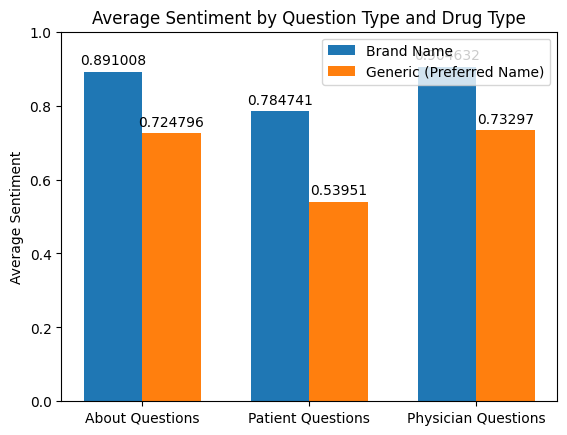

In [13]:
df_1= dataframes[0]

# Separate the data into brand names and preferred (generic) names
brand_data = df_1[df_1["string_type"] == "brand"]
generic_data = df_1[df_1["string_type"] == "preferred"]

# Calculate average sentiment for each question type for both brand and generic drugs
avg_sentiment_about_brand = brand_data["sentiment_inferred_question_about"].mean()
avg_sentiment_patient_brand = brand_data["sentiment_inferred_question_patient"].mean()
avg_sentiment_physician_brand = brand_data["sentiment_inferred_question_physician"].mean()

avg_sentiment_about_generic = generic_data["sentiment_inferred_question_about"].mean()
avg_sentiment_patient_generic = generic_data["sentiment_inferred_question_patient"].mean()
avg_sentiment_physician_generic = generic_data["sentiment_inferred_question_physician"].mean()

# Now, let's plot these values
labels = ["About Questions", "Patient Questions", "Physician Questions"]
brand_values = [avg_sentiment_about_brand, avg_sentiment_patient_brand, avg_sentiment_physician_brand]
generic_values = [avg_sentiment_about_generic, avg_sentiment_patient_generic, avg_sentiment_physician_generic]

x = range(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, brand_values, width, label="Brand Name")
rects2 = ax.bar([p + width for p in x], generic_values, width, label="Generic (Preferred Name)")

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel("Average Sentiment")
ax.set_title("Average Sentiment by Question Type and Drug Type")
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

# Adding some aesthetics to make the plot more readable
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
plt.ylim(0, 1)  # Assuming sentiment values are normalized between 0 and 1

plt.show()

In [17]:
# Assuming 'dataframes' is a list of DataFrame objects and 'temperatures' is a list of corresponding temperatures
for i, df in enumerate(dataframes):
    # Separate the data into brand names and preferred (generic) names
    brand_data = df[df["string_type"] == "brand"]
    generic_data = df[df["string_type"] == "preferred"]

    # Calculate average sentiment for each question type for both brand and generic drugs
    avg_sentiment_about_brand = brand_data["sentiment_inferred_question_about"].mean()
    avg_sentiment_patient_brand = brand_data["sentiment_inferred_question_patient"].mean()
    avg_sentiment_physician_brand = brand_data["sentiment_inferred_question_physician"].mean()

    avg_sentiment_about_generic = generic_data["sentiment_inferred_question_about"].mean()
    avg_sentiment_patient_generic = generic_data["sentiment_inferred_question_patient"].mean()
    avg_sentiment_physician_generic = generic_data["sentiment_inferred_question_physician"].mean()

    # Define labels and values for plotting
    labels = ["About Questions", "Patient Questions", "Physician Questions"]
    brand_values = [avg_sentiment_about_brand, avg_sentiment_patient_brand, avg_sentiment_physician_brand]
    generic_values = [avg_sentiment_about_generic, avg_sentiment_patient_generic, avg_sentiment_physician_generic]

    x = range(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    # Plotting
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, brand_values, width, label='Brand Name')
    rects2 = ax.bar([p + width for p in x], generic_values, width, label='Generic (Preferred Name)')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Average Sentiment')
    ax.set_title(f'Average Sentiment by Question Type and Drug Type at Temperature {temperatures[i]}')
    ax.set_xticks([p + width / 2 for p in x])
    ax.set_xticklabels(labels)
    ax.legend()

    # Adding some aesthetics to make the plot more readable
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    plt.ylim(0, 1)  # Assuming sentiment values are normalized between 0 and 1

    # save fig
    dir_path = os.path.join(output_dir, ENGINE, f"{temperatures[i]} sentiment_df")
    os.makedirs(dir_path, exist_ok=True)
    
    # Save the plot
    plot_path = os.path.join(dir_path, "avg_sentiment_plot.png")
    plt.savefig(plot_path)
    plt.close()
    
    plt.show()

In [18]:
def calculate_sentiment_counts(data):
    sentiment_counts_patient = data["sentiment_inferred_question_patient"].value_counts().sort_index()
    sentiment_counts_about = data["sentiment_inferred_question_about"].value_counts().sort_index()
    sentiment_counts_physician = data["sentiment_inferred_question_physician"].value_counts().sort_index()
    
    # Ensure all sentiment categories are represented, even if they have 0 count
    for sentiment in [0.0, 0.5, 1.0]:
        if sentiment not in sentiment_counts_patient:
            sentiment_counts_patient[sentiment] = 0
        if sentiment not in sentiment_counts_about:
            sentiment_counts_about[sentiment] = 0
        if sentiment not in sentiment_counts_physician:
            sentiment_counts_physician[sentiment] = 0
    
    return sentiment_counts_patient, sentiment_counts_about, sentiment_counts_physician

# Loop through each DataFrame and its associated temperature
for i, df in enumerate(dataframes):
    # Separate the data into brand names and preferred (generic) names
    brand_data = df[df["string_type"] == "brand"]
    generic_data = df[df["string_type"] == "preferred"]
    
    # Calculate sentiment counts for brand and generic drugs
    sentiment_counts_patient_brand, sentiment_counts_about_brand, sentiment_counts_physician_brand = calculate_sentiment_counts(brand_data)
    sentiment_counts_patient_generic, sentiment_counts_about_generic, sentiment_counts_physician_generic = calculate_sentiment_counts(generic_data)
    
    # Data preparation for stacked bar plot
    labels = [
        "Patient Questions - Brand", "About Questions - Brand", "Physician Questions - Brand",
        "Patient Questions - Generic", "About Questions - Generic", "Physician Questions - Generic",
    ]
    negative_sentiments = [
        sentiment_counts_patient_brand[0], sentiment_counts_about_brand[0], sentiment_counts_physician_brand[0],
        sentiment_counts_patient_generic[0], sentiment_counts_about_generic[0], sentiment_counts_physician_generic[0],
    ]
    neutral_sentiments = [
        sentiment_counts_patient_brand[0.5], sentiment_counts_about_brand[0.5], sentiment_counts_physician_brand[0.5],
        sentiment_counts_patient_generic[0.5], sentiment_counts_about_generic[0.5], sentiment_counts_physician_generic[0.5],
    ]
    positive_sentiments = [
        sentiment_counts_patient_brand[1], sentiment_counts_about_brand[1], sentiment_counts_physician_brand[1],
        sentiment_counts_patient_generic[1], sentiment_counts_about_generic[1], sentiment_counts_physician_generic[1],
    ]
    
    x = range(len(labels))  # the label locations
    
    # Plotting
    fig, ax = plt.subplots()
    ax.bar(labels, negative_sentiments, label="0 (Negative)", color="red")
    ax.bar(labels, neutral_sentiments, bottom=negative_sentiments, label="0.5 (Neutral)", color="gray")
    ax.bar(labels, positive_sentiments, bottom=[i + j for i, j in zip(negative_sentiments, neutral_sentiments)], label="1 (Positive)", color="green")
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("Counts")
    ax.set_title(f"Sentiment Distribution by Question Type and Drug Type at Temperature {temperatures[i]}")
    ax.legend()
    
    plt.xticks(rotation=45)
    
    # save fig
    dir_path = os.path.join(output_dir, ENGINE, f"{temperatures[i]} sentiment_df")
    os.makedirs(dir_path, exist_ok=True)
    
    # Save the plot
    plot_path = os.path.join(dir_path, "sentiment_plot.png")
    plt.savefig(plot_path)
    plt.close()

    plt.show()
    


## Save


In [16]:
for i, df in enumerate(dataframes):
    # Construct the directory path
    dir_path = os.path.join(output_dir, ENGINE, f"{temperatures[i]} sentiment_df")
    
    # Ensure the directory exists
    os.makedirs(dir_path, exist_ok=True)
    
    # Specify the file path
    file_path = os.path.join(dir_path, "sentiment_data.csv")
    
    # Save the DataFrame to a CSV file
    df.to_csv(file_path, index=False)
    
    print(f"Saved DataFrame for temperature {temperatures[i]} at: {file_path}")


Saved DataFrame for temperature 0.0 at: ../results/sentiment/gpt-3.5-turbo-0613/0.0 sentiment_df/sentiment_data.csv
Saved DataFrame for temperature 0.5 at: ../results/sentiment/gpt-3.5-turbo-0613/0.5 sentiment_df/sentiment_data.csv
Saved DataFrame for temperature 1.0 at: ../results/sentiment/gpt-3.5-turbo-0613/1.0 sentiment_df/sentiment_data.csv
Saved DataFrame for temperature 2.0 at: ../results/sentiment/gpt-3.5-turbo-0613/2.0 sentiment_df/sentiment_data.csv
